# Thin plate inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/thin_plate_inversion/thin_plate_inversion.ipynb)

---

## What we do in this notebook

When modelling the airborne electromagnetic response of subvertical bodies such as a volcanogenic massive sulfide deposit they can be approximated using a thin plate in the halfspace of a layered earth, that is the 3D response of a thin plate is being considered. Here we use CoFI to infer such a thin plate target in the basement of a layered earth given airborne electromagnetic data. This tutorial provides a guided tour of a subset of the material in [`cofi-examples/examples/vtem_max`](https://github.com/inlab-geo/cofi-examples/tree/main/examples/vtem_max)

---

## Learning outcomes 

- An understaning of the pitfalls around using a numerical gradient
- An exposé of CoFI's ability to combine a forward solver and a range of inference methods
- An appreciation of the fact that CoFI only requires limited information about the forward problem


In [1]:
# Environment setup (uncomment code below)
# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git
# !pip install smt

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/tutorials/thin_plate_inversion

## Problem description

Given airborne electromagentic data a common goal in mineral exploration is to detect and delineate an econcomic target, and if this target is in the form of a subvertical body in the basement, its electromagnetic response can be approximated using at conductive thin plate located in the halfspace of a layered earth (e.g. Prikhodko et al. 2019). 

In this tutorial we look at the inference of such a thin plate with a conductance of $2 \mathrm{S}$ located in a halfspace with a resistivity of $1000 \mathrm{\Omega m}$ with a $20 \mathrm{m}$ thick covering layer that has a resistivity of $300 \mathrm{\Omega m}$. Specfically we develop a thin plate inversion method using CoFI to solve the inverse problem and P223 (Raiche et. al., 2007) to solve the forward problem. 

<img src="https://github.com/inlab-geo/cofi-examples/blob/main/data/pyp223/wpar8wl.png?raw=true" width=30%> 


### Forward solver

The forward solver is LeroiAir (Raiche et. al, 2007) and the code has been reorganised so that the response measured by an AEM system here VTEMmax is given by a function that can be called from Python. In LeroiAir plates are discretised into cells, with the accuracy of the forward solver being a function of the chosen cell-size. The forward solver is available in a seperate Python package that is available [here](https://github.com/JuergHauser/PyP223.git)

Successful inversion frequently relies on the objective function being smooth and predictable. For the data being inverted here it is advantageous to convert measurements to scale logarithmically to obtain a smoother and more predictable objective function when compared with using the unscaled data. Similarly plate orientation angles are converted into radians. 

#### Jacobian via finite differencing

Parameter estimation methods often rely on the provision of a Jacobian for efficient optimisation. If an analytical Jacobian is not available it can be computed via finite differencing.

$
f'(x_0) = {f(x_0 +h)-f(x_0)\over h}
$

Care must though be taken when choosing the step size $h$, as a too small step size may result in a Jacobian that is affected by a limited accuracy of a forward solver and a too large step size $h$ might result in a Jacobian that is not representative of the derivatives at location $x_0$. Further to this the gradient of the objective function itself is affected by the noise on the data, thus for noisy data choosing a larger step size when computing the Jacobian can be advisable. 

In the following we will be using a relative step size $q$ with $h$ defined as $h=x0*(1.0+q)$. 

#### VTEMmax AEM system

Airborne electromagnetic systems can be categorised into either helicopter or fixed wing systems. This tutorial is using a VTEMmax system, a helicopter based system developed and operated by Geotech.

https://geotech.ca/services/electromagnetic/vtem-versatile-time-domain-electromagnetic-system/


### Plate parametrisation

The thin plate is parameterised using the parametrisation introduced in (Hauser et. al. 2016). Compared to the commonly employed parametrisation with a plate reference point on the edge of the plate this parametrisation allows for a thin plate to grow and shrink around a plate refrerence point, without the need to move the reference point. This can be advantageous  when there is for example a borehole intersecting a thin plate and we seek to determine the extent of the thin plate.

<img src="https://github.com/inlab-geo/cofi-examples/blob/main/data/pyp223/wpar7wl.png?raw=true" width=80%> 


### Implementation details

The problem setup is imported from `forward_lib.py` but can be adjusted for other applications. The wrapper is created so that we can declare model parameters which are a subset of all the model parameters required by the forward problem. This allows to, for example, invert only for dip of the thin plate with all the other mode paremters assumed to be known. 



### Further reading

Hauser, J., Gunning, J., & Annetts, D. (2016). Probabilistic inversion of airborne electromagnetic data for basement conductors. Geophysics, 81(5), E389-E400.

Prikhodko, A., Morrison, E., Bagrianski, A., Kuzmin, P., Tishin, P., & Legault, J. (2010). Evolution of VTEM? technical solutions for effective exploration. ASEG Extended Abstracts, 2010(1), 1-4.

Raiche, A., Sugeng, F. and Wilson, G. (2007) Practical 3D EM inversion the P223F software suite, ASEG Extended Abstracts, 2007:1, 1-5

Wheelock, B., Constable, S., & Key, K. (2015). The advantages of logarithmically scaled data for electromagnetic inversion. Geophysical Journal International, 201(3), 1765–1780. https://doi.org/10.1093/GJI/GGV107


In [3]:
# import libraries needed for this example

import pickle
import functools
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import arviz
import cofi
import bayesbay
import smt

from vtem_max_forward_lib import (
    problem_setup, 
    system_spec,
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient,
    plot_predicted_profile,
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

### Problem definition
For convenience we split the problem defintion into three objects that are intialised  with defaults for our synthetic example introduced in the problme description section. 

- System specification - `system_spec` - contains information about the AEM system such as the transmitter waveform as well as start and end times of gates.
- Survey setup - `survey_setup` - contains information about the survey for example the transimtter and receiver locations.
- Problem setup  - `problem_setup` - The problem setup cotains the model and exposes the declared moel parameters to CoFI.


In [4]:
survey_setup = {
    "tx": numpy.array([205.]),                  # transmitter easting/x-position
    "ty": numpy.array([100.]),                  # transmitter northing/y-position
    "tz": numpy.array([50.]),                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90.])),  # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6.])),  # transmitter inclination
    "rx": numpy.array([205.]),                  # receiver easting/x-position
    "ry": numpy.array([100.]),                  # receiver northing/y-position
    "rz": numpy.array([50.]),                   # receiver height/z-position
    "trdx": numpy.array([0.]),                  # transmitter receiver separation inline
    "trdy": numpy.array([0.]),                  # transmitter receiver separation crossline
    "trdz": numpy.array([0.]),                  # transmitter receiver separation vertical
}

# Inverting for the dip of a thin plate

While a thin plate can not be recoverd from a single fiducial, its dip can be recovered form a carefully positioned fiducial. When setting up an inverse rpoblem it is good practice to initailly setup a the simplest possible problem and experiment with it to ensure that the forward solver and inference methods work as intendend. Before attempting an inversion it also is good practice to verify that the misfit function is sensitve to the parameter of itnerest and that the gradient of the objective function points in the right direction.

Thus the dip of the thin plate which becomes our declared model parameter and we create the corresponding forward function and set the true value to $60\degree$

In [5]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup, ["pdip"])
true_param_value = numpy.array([60])

['pdip']


## Problem setup

### True model

We first the plot the true model and the location of the VTEMmax measurement, which we will be inverting.

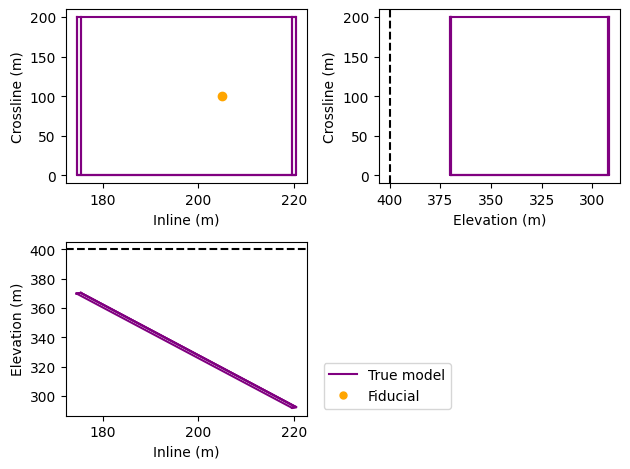

In [6]:
#@title plotting function (hidden)
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])
axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

### Generate synthetic data 

This tutorial uses a simplified noise model that assumes an absolute noise, that is a standard deviation of $0.05$ for the logarithms of the measured and observed data. In the objective and likelihood funtions the noise model is captured in the data covariance matrix, thus a more sophisticated noise model for example one that accounts for the known corrleation between time gates in AEM data could easily be implemented.

In [7]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

### Starting model

Set an initial guess for the dip of the thin plate

In [8]:
init_param_value = numpy.array([45])

## Define helper functions for CoFI

### Challenge: Choose relative step size for the numerical Jacobian

To compute the numerical Jacobian we need to choose the step size for the perturbation. Here we use a relative step size and if the chosen step size is too large the gradient of the objective function may miss the global minimum if it is located in a small basins of attraction and thus an inversion may never converge. If the step size is chosen too small the gradient of the objective function will be affected by the noise on the data and the numerical noise of the forward problem.  Thus the smallest step size providing a stable gradient is the ideal step size.

*Experiment with relative stape size in the range between $0.01$ and $0.5$ and upload the figure of the gradient and misfit function as a function of plate dip*

[![Upload to Excalidraw_1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=f4481f8278ad2ddcb96d,i9Ki_GouExK4GylmrsrZ2A)


Using the template below se the relative step size

```
my_relative_step = <DEFINE_ME>

def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step = my_relative_step)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model, relative_step = my_relative_step)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1
```

In [9]:
# Copy the template above, Replace <DEFINE ME> with your answer

In [10]:
#@title Solution

my_relative_step = 0.1

def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step = my_relative_step)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model, relative_step = my_relative_step)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

### Plot the misfit and gradient as a function of the plate dip

pdip: [40], data misfit: 231.708835656254, gradient: [-8.38525334]
pdip: [45], data misfit: 161.52059630302878, gradient: [-5.17711959]
pdip: [50], data misfit: 115.89689554155724, gradient: [-3.41393833]
pdip: [55], data misfit: 91.0843855955822, gradient: [-1.79238028]
pdip: [60], data misfit: 78.13208270691166, gradient: [-0.40612889]
pdip: [65], data misfit: 79.47542276986738, gradient: [0.60701868]
pdip: [70], data misfit: 86.57794284916837, gradient: [0.77951888]
pdip: [75], data misfit: 99.82377503892143, gradient: [1.04776418]
pdip: [80], data misfit: 114.82121927725917, gradient: [1.88028555]
pdip: [85], data misfit: 135.80364266137616, gradient: [1.99672184]
pdip: [90], data misfit: 158.91312196239573, gradient: [2.12201565]
pdip: [95], data misfit: 190.36506697630017, gradient: [1.90338506]
pdip: [100], data misfit: 211.34574782298415, gradient: [3.0843773]
pdip: [105], data misfit: 248.95857134110955, gradient: [3.54243063]
pdip: [110], data misfit: 283.9454162116735, gradi

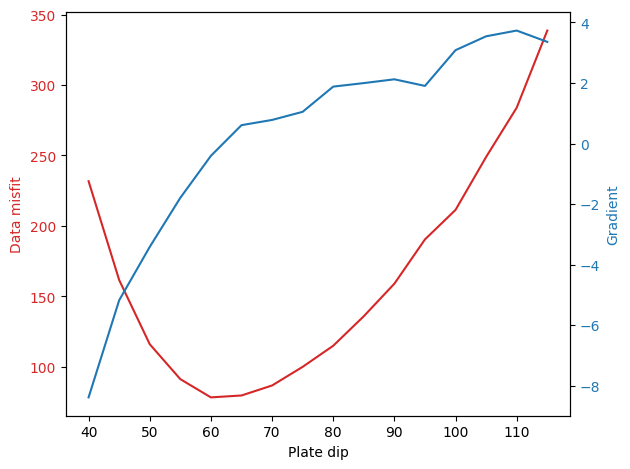

In [11]:
#@title plotting function (hidden)

all_models = [numpy.array([pdip]) for pdip in range(40, 120, 5)]
all_misfits = []
all_gradients = []
for model in all_models:
    misfit = my_objective(model)
    gradient = my_gradient(model)
    all_misfits.append(misfit)
    all_gradients.append(gradient)
    print(f"pdip: {model}, data misfit: {misfit}, gradient: {gradient}")


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(all_models, all_misfits,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel("Plate dip")
ax1.set_ylabel("Data misfit",color=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.plot(all_models, all_gradients,color=color)
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Parameter estimation

First we solve the inverse problem using optimisation that is we seek to find the minimum of the objective function given as

$$
\chi^2 = (\mathbf{d} - \mathbf{f}(\mathbf{m}))^T\mathbf{C}_d^{-1}(\mathbf{d}-\mathbf{f}(\mathbf{m})),
$$

with the full Newton step being

$$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{y}-\mathbf{f}(\mathbf{m}))}_\mathbf{Gradient}).
\end{equation} 
$$

The Jacobian and Hessian are only local measures of the first and second derivatives of the objective 
function and given this a non-linear inverse problem and the numericla derivates can be affected by noise, we can seldom  take the full Newton step to compute a model update as we are likely to overshoot and not improve fit to the data.

One strategy is to employ a line search to determine the optimal step length, that means the  descent 
direction is given by the full Newton Step with the length adjusted so that it does not overshoot 
and results in an improvement of the fit to the data. The major alternative to employing a line search 
is to use a trust region method. Trust regions methods try to estimate the region around the current 
model within which  the assumption of local linearity holds and then limit the model update to 
stay within that region.

### Further reading

https://medium.com/intro-to-artificial-intelligence/line-search-and-trust-region-optimisation-strategies-638a4a7490ca


#### Define CoFI problem

In [12]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

#### Define CoFI options

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

#### CoFI inversion

In [14]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 77.89136366904667
Iteration #2
  objective value: 77.67785905000744
[59.18480808]


### Plotting

#### Data

In the following we plot the vertical and inline component for the true model, the starting model and the MAP model that is the maximum a posterior model, the solution found by the chosen optimisation method.

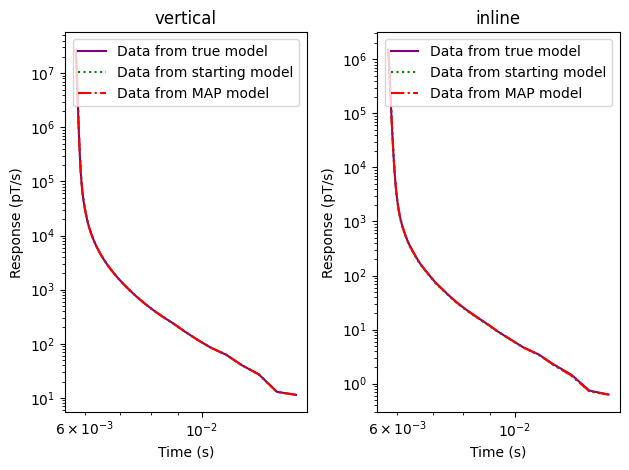

In [15]:
#@title plotting function (hidden)
_, (ax1, ax2) = plt.subplots(1, 2)
plot_transient(true_param_value, forward, "Data from true model", ax1, ax2, color="purple")
plot_transient(init_param_value, forward, "Data from starting model", ax1, ax2, color="green", linestyle=":")
plot_transient(my_result.model, forward, "Data from MAP model", ax1, ax2, color="red", linestyle="-.")
ax1.legend(loc="upper center")
ax2.legend(loc="upper center")
ax1.set_title("vertical")
ax2.set_title("inline")
plt.tight_layout()

#### Model

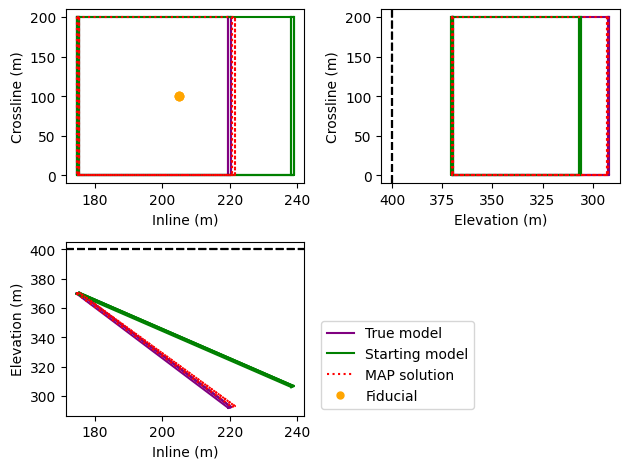

In [16]:
#@title plotting function (hidden)

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP solution", linestyle="dotted"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

## Ensemble method

Parameter estimation methods require an objective function while ensemble methods require a likelihood functions typically given in the form of a log likelidhood function. 
The objective function used for the parameter estimation consists of only a data misfit term and thus is closely related to the likelihood function, with the log likelihood  being proportional to the value of the objective function multiplied by a factor of $\frac{1}{2}$

$$
p({\mathbf d} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}-{\mathbf f}({\mathbf m}))^T C_d^{-1} ({\mathbf d}-{\mathbf f}({\mathbf m})) \right\}
$$

To use an ensemble method in CoFI we will need to define a likelihood function and  prior distribution. The prior distribution is a uniform distribution with an lower boundary of $10 \degree$ and an upper boundary of $80 \degree$. 


In [ ]:
m_min=numpy.array([10])
m_max=numpy.array([80])

def my_log_prior(m):    # uniform distribution
    for i in range(len(m)):
        if m[i] < m_min[i] or m[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

### Challenge: Given the objective function define a log likelihood function.

In the previous section we defined the following objective function.

In [ ]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

This function can be used to now create the log likelihood function typically needed by the ensemble methods made available in CoFI.

In [ ]:
def my_log_likelihood(model):
    return # DEFINE ME

In [ ]:
#@title Solution
def my_log_likelihood(model):
    return -0.5 * my_objective(model)

### Augment the CoFI problem

To finally be able to use an ensemble method we also need to augment our CoFI problem with the functions we defined for the log of the prior probability and the log of the likelihood function. We will again be using `emcee`, which we already used in the linear regression tutorial.

In [ ]:
my_problem.set_log_prior(my_log_prior)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_model_shape(len(init_param_value))

### Define CoFI options

In [ ]:
nwalkers = 3
ndim = len(init_param_value)
nsteps = 250
walkers_start = init_param_value + 1 * numpy.random.randn(nwalkers, ndim)

### CoFI Inversion

In [ ]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
my_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
my_result.summary()

In [ ]:
#@title plotting function (hidden)
sampler = my_result.sampler
arviz.style.use("default")
var_names = [
    "plate dip (\u00b0)", 
]
az_idata = my_result.to_arviz(var_names=var_names)
arviz.plot_trace(az_idata.sel(draw=slice(50,None)),lines=(('plate dip (\u00b0)', {}, 60),));
plt.tight_layout()

# Inverting for a thin plate given three survey lines

A more realistic synthetic example is the inference of a thin plate target given three survey lines. It now becomes possible to invert for the easting, depth of the plate reference point, the plate dip and plate azimuth and the plate length.


## Problem setup

In the following we define three survey lines covering the thin plate

In [17]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = numpy.arange(tx_min, tx_max, tx_interval)
ty_points = numpy.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = numpy.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [18]:
fiducial_id = numpy.arange(len(tx))
line_id = numpy.zeros(len(tx), dtype=int)
line_id[ty==ty_points[0]] = 0
line_id[ty==ty_points[1]] = 1
line_id[ty==ty_points[2]] = 2

In [19]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

### True model

In [20]:
true_model = {
    "res": numpy.array([300, 1000]), 
    "thk": numpy.array([20]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

We now increase the number of declared model parameters and they include the plate dip, the plate dip azimuth, the easting of the plate reference point, the depth of the plate reference point and the plate width and will only be using the vertical component.

As a general rule we can only constrain parameters if there are fiducials in the survey that are sensitive to them and also fiducials that are not sensitive to them. In order words the anomly needs to be closed with respect to the model paratmeter in question. So to be able to constraint plate length we would need survey lines to the north and south that are not overflying the thin plate, as this is not the case we do not invert for plate length.

In [21]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "pwdth2","ptop"], data_returned=["vertical"]);

['pdip', 'pdzm', 'peast', 'pwdth2', 'ptop']


In [22]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [23]:
true_param_value = numpy.array([60,65, 175, 30, 90])

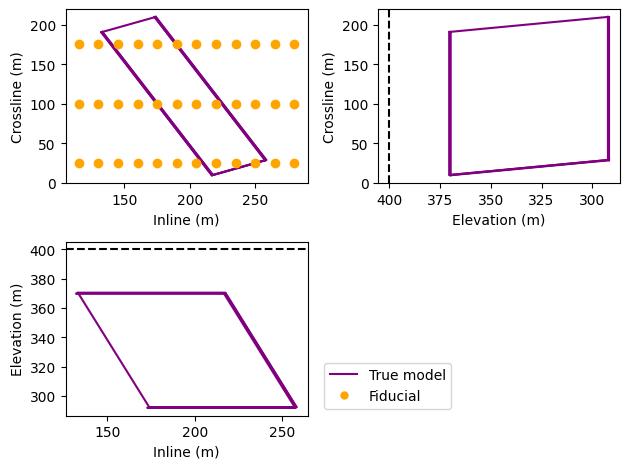

In [24]:
#@title plotting function (hidden)

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

### Generate synthetic data

We again generate a synthetic data set and add a realisation of the noise.

In [25]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

##  Challenge: Implement a parameter estimation or ensemble method in CoFI

CoFI is about experimentation and given the experiments in the previous section you can now head down a branch of the CoFI tree and infer a thin plate from the synthetic data we just generated.  The first choice is between Parameter estimation and ensemble methods. 

- [Parameter estimation](#Parameter-estimation-applied-to-three-survey-lines)
- [Ensemble methods](#Ensemble-methods-applied-to-three-survey-lines)

If you are running this example on

*Once you have performed an inversion using CoFI upload your solution*

[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)



## Parameter estimation applied to three survey lines

**Initialise a model for inversion**

In [26]:
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [27]:
init_param_value = numpy.array([45, 90, 150, 20, 80])

**Define helper functions for CoFI**

In [28]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [29]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

### Challenge: Choose a parameter estimation method

CoFI provides access to the pareamter estimation methodsthat are available in

scipy.optimize.minimize https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

For practical application we are interested in a solver that converges with the fewest calls to the 
forward problem to a model that is acceptably close to the true model and explains the data. 
The consequence of employing a line search or trust region method or more broadly any 
method seeking to find the optimal step length is that typically additional calls to 
a forward problem need to be made to determine the optimal step length and different 
approaches require different numbers of calls to the forward problem depending on 
the shape of the objective function.

*Choose one of the following two solvers and perform a parameter estimation using CoFI and upload your solution *
- `newton-cg` - https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html
- `trust-ncg`- https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustncg.html

[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)

**Define CoFI options**


Use the template below and set the CoFI tool to `newton-cg` or `trust-ncg`
```
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method=<DEFINE_ME>,callback=PerIterationCallbackFunction(),options={"maxiter": 10})

```

In [30]:
# Copy the template above, Replace <DEFINE ME> with your answer

In [31]:
#@title Solution newton-cg
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="newton-cg",callback=PerIterationCallbackFunction(),options={"maxiter": 10})

In [32]:
#@title Solution trust-ncg
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="trust-ncg",callback=PerIterationCallbackFunction(),options={"maxiter": 10})

**Run CoFI inversion**

In [33]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(f"\nNumber of objective function evaluations: {my_result.nfev}")
print(f"Number of gradient function evaluations: {my_result.njev}")
print(f"Number of hessian function evaluations: {my_result.nhev}")
print(f"Solution vector:\n",my_result.model)

Iteration #1
  objective value: 81579.50296734908
Iteration #2
  objective value: 68773.62152198318
Iteration #3
  objective value: 49252.70559469344
Iteration #4
  objective value: 27701.82794478798
Iteration #5
  objective value: 13399.602494747473
Iteration #6
  objective value: 8740.136906604443
Iteration #7
  objective value: 3919.516148144549
Iteration #8
  objective value: 2326.8366784823816
Iteration #9
  objective value: 1972.830835768742
Iteration #10
  objective value: 1672.0325795427207

Number of objective function evaluations: 11
Number of gradient function evaluations: 11
Number of hessian function evaluations: 24
Solution vector:
 [ 57.26170988  65.38059683 177.00411573  31.60064704  89.56751948]


### Plotting

#### Data - Profiles

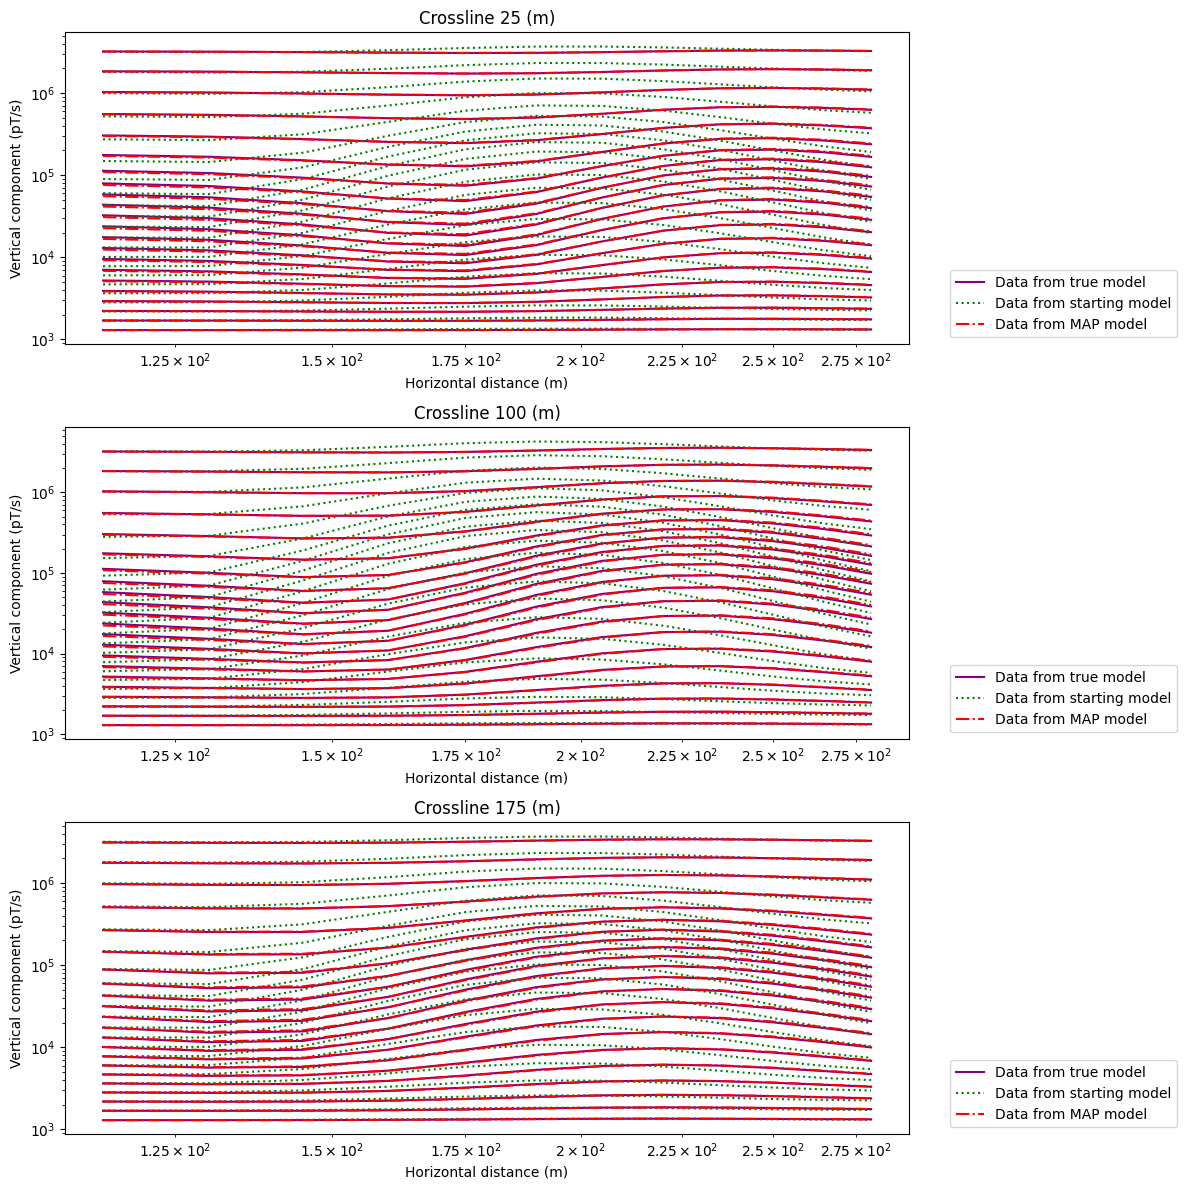

In [34]:
#@title plotting function (hidden)

# Select gates to plot
idx_to_plot = numpy.arange(8, 30) 

_, axes = plt.subplots(3, 1, figsize=(12,12))

for i in range(3):
    plot_predicted_profile(true_param_value, forward, "Data from true model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="purple")
    plot_predicted_profile(init_param_value, forward, "Data from starting model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="green", linestyle=":")
    plot_predicted_profile(my_result.model, forward, "Data from MAP model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="red", linestyle="-.")
    axes[i].set_title("Crossline {} (m)".format(ty_points[i]))
    axes[i].legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()

#### Model

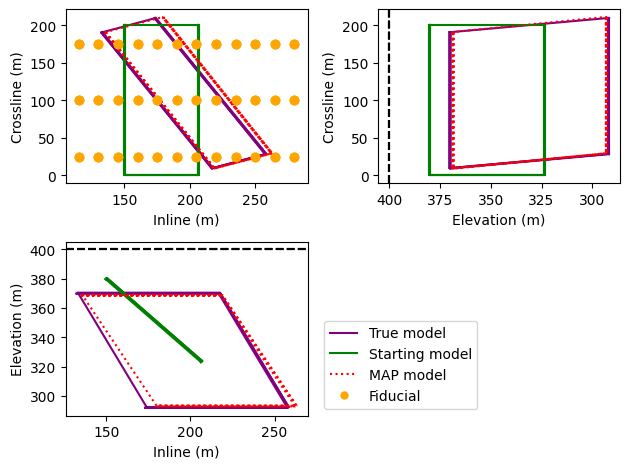

In [35]:
#@title plotting function (hidden)

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP model", linestyle="dotted"
)

plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

## Ensemble methods applied to three survey lines

To speed up the forward computations for this tutorial and to be able to use ensemble methods we created a surrogate model for the objective function. The surrogate model is created using [the surrogate modelling toolbox](https://smt.readthedocs.io/en/latest/) and here loaded from disk. 

The two steps to create the surrogate model are the sampling of the objective function using latin hypercube smapling and the the creation of the surrogate model itself that is here the construction of a response surface using Kriging. For completness the two notebooks implementing this are given here:
- [Latin Hypercube Sampling](./three_survey_lines_latin_hypercube_sampling.ipynb)
- [Surrogate model creation](./three_survey_lines_surrogate_model_creation.ipynb)



In [ ]:
#@title Create surrogate model given latin hypercube samples

# Different versions of the surrogate modelling toolbox store the model in different
# formats thus it is safer to just create the model on the fly given the latin hypercube
# samples which are pre-computed.

with open('three_survey_lines_lhs.npy', 'rb') as f:
    ndim=int(numpy.load(f))
    xlimits=numpy.load(f) 
    xtrain=numpy.load(f)
    ytrain=numpy.load(f)
    xtest=numpy.load(f)
    ytest=numpy.load(f)

xlimits=xlimits.astype('double')
xtrain=xtrain[0:100].astype('double')
ytrain=ytrain[0:100].astype('double')
xtest=xtest[0:10].astype('double')
ytest=ytest[0:10].astype('double')

sm = smt.surrogate_models.KRG(theta0=[1e-2]*ndim,print_prediction = False)
sm.set_training_values(xtrain,ytrain)
sm.train()

**Initialise a model for inversion**

In [ ]:
init_param_value = numpy.array([45, 90, 160, 35, 80])
m_min = numpy.array([15, 35, 155, 30, 65])
m_max = numpy.array([75, 145, 185, 40, 115])

**Define helper functions for CoFI**

In [ ]:
def my_objective(model):
    val=sm.predict_values(numpy.array([model]))[0][0]
    if val<1e-3:
        return 1e-3
    else:
        return val
        
def my_log_likelihood(model):
    return -0.5 * my_objective(model)


def my_log_prior(model):    # uniform distribution
    for i in range(len(model)):
        if model[i] < m_min[i] or model[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

### Challenge: Select an ensemble method

The nature of the airborne  electromagnetic forward physics is that the deeper a feature of interest the less well it can be reocvered. This information is not captured in the solution obtained using a parameter estmation method in the previous section. CoFI provides access to range of esnemble  methods that recover the distribution of models that fit the data and thus allows estimate model uncertainty.

*Using one of the following three ensemble methods available in CofI complete the relevant section and upload your solution*

- [`emcee` Affine Invariant Markov chain Monte Carlo Ensemble sampler](#Affine-Invariant-Markov-chain-Monte-Carlo-Ensemble-sampler)
- [`neighpy` Neighbourhood algorithm](#Neighbourhood-algorithm)
- [`bayesbay` Reversible jump Markov chain Monte Carlo](#Reversible-jump-Markov-chain-Monte-Carlo)


[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)

### Affine Invariant Markov chain Monte Carlo Ensemble sampler

Using `emcee` as the string in `inv_options.set_tool()` CoFI offers an interface to the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler by
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the posterior distribution. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).


[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)

In [ ]:
my_problem = cofi.BaseProblem()
my_problem.set_log_prior(my_log_prior)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_model_shape(len(init_param_value))

**Define CoFI options**

In [ ]:
#@title defaults for emcee
nwalkers = 12
ndim = len(init_param_value)
nsteps = 5000
walkers_start = init_param_value + 0.5 * numpy.random.randn(nwalkers, ndim)

Use the template below and set the CoFI tool to `emcee`
```
inv_options = cofi.InversionOptions()
inv_options.set_tool(<DEFINE_ME>)
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
my_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
my_result.summary()
```

In [ ]:
# Copy the template above, Replace <DEFINE ME> with your answer

In [ ]:
#@title Solution

inv_options = cofi.InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
my_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
my_result.summary()

In [ ]:
## Plotting

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")

var_names = [
    "Dip (\u00b0)",
    "Dip azimuth (\u00b0)",
    "Easting (m)",
    "Depth (m)",
    "Width (m)",
]

var_lines=(
        ('Dip (\u00b0)', {}, 60),
        ('Dip azimuth (\u00b0)', {}, 65),
        ('Easting (m)', {}, 175),
        ('Depth (m)', {}, 30),
        ('Width (m)', {}, 90)
)
sampler = my_result.sampler
az_idata = my_result.to_arviz(var_names=var_names)
arviz.plot_trace(az_idata.sel(draw=slice(2000,None)),lines=var_lines);
plt.tight_layout()

In [ ]:
#@title plotting function (hidden)

true_values = {
    f"{var_names[i]}": true_param_value[i] for i in range(init_param_value.size)
}
fig, axes = plt.subplots(5, 5, figsize=(10, 8))
_ = arviz.plot_pair(
az_idata.sel(draw=slice(4000,None)), 
    marginals=True,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    ax=axes,
    textsize=10,
)

for i, j in numpy.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]        
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=10, markeredgecolor="k")

plt.show()

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)


plt.tight_layout()


ichain=0
idraw=2500
sample=numpy.zeros(5)

sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distirbution
for i in range(10):
    ichain=numpy.random.randint(0,12)
    idraw=numpy.random.randint(2000,5000)
    sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
    sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
    sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
    sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
    sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
    plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)


### Neighbourhood algorithm

The [Neighbourhood Algorithm](https://iearth.edu.au/codes/NA/#:~:text=Overview-,The%20neighbourhood%20algorithm%20is%20a%20two%2Dstage%20numerical%20procedure%20for,in%20a%20multidimensional%20parameter%20space.) is a two-stage Ensemble method for non-linear inverse problems with application as a direct search method for global optimisation. The first stage seeks to find points in model space with acceptable values of the the objective function. The second stage analysis the ensemble of models generated in the first stage and provides Bayesian measures of properties of the ensemble such a resolution and covariance structure. 

Here CoFI is providing an interface the the implementation of the Neighbourhood Algorithm provided by [neighpy](https://neighpy.readthedocs.io/en/latest/) and it is accessed by using `neighpy` as the string in `inv_options.set_tool()` 


[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)

In [ ]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)

Using the template below set the CoFI  tool to `neighpy`
```
inv_options = cofi.InversionOptions()
inv_options.set_tool(<DEFINE_ME>)
inv_options.suggest_solver_params()
```

In [ ]:
# Copy the template above, Replace <DEFINE ME> with your answer

In [ ]:
#@title Solution
inv_options = cofi.InversionOptions()
inv_options.set_tool("neighpy")
inv_options.suggest_solver_params()

In [ ]:

inv_options.set_params(
    direct_search_ni=1000,
    direct_search_ns=100,
    direct_search_nr=20,
    direct_search_n=10,
    bounds=numpy.array([m_min, m_max]).T,
    appraisal_n_resample=10000,
    appraisal_n_walkers=4
)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
my_result = inv.run()

######## Check result
print(f"The inversion result from `neighpy`:")
my_result.summary()

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")
var_names = [
    "Dip (\u00b0)", 
    "Dip azimuth (\u00b0)", 
    "Easting (m)", 
    "Depth (m)", 
    "Width (m)"
]

var_lines=(
    ('Dip (\u00b0)', {}, 60),
        ('Dip azimuth (\u00b0)', {}, 65),
        ('Easting (m)', {}, 175),
        ('Depth (m)', {}, 30),
        ('Width (m)', {}, 90)
)
d = {k: v for k, v in zip(var_names, my_result.appraisal_samples.T)}
az_idata = arviz.convert_to_inference_data(d)
arviz.plot_trace(az_idata.sel(draw=slice(2000,None)),lines=var_lines)
plt.tight_layout()

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")

_, axes = plt.subplots(5, 5, figsize=(12,12))
arviz.plot_pair(
    az_idata.sel(draw=slice(4000,None)), 
    marginals=True, 
    ax = axes
)
plt.tight_layout()

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)


plt.tight_layout()


ichain=0
idraw=2500
sample=numpy.zeros(5)

sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distirbution
for i in range(10):
    idraw=numpy.random.randint(2000,5000)
    sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
    sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
    sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
    sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
    sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
    plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)


### Reversible jump Markov chain Monte Carlo

To sample the posterior distribution, [BayesBay](https://github.com/fmagrini/bayes-bay) implements an RJ-MCMC method, which is a generalization of the Metropolis-Hastings algorithm  allowing for trans-dimensional inference. Here we use [BayesBay](https://github.com/fmagrini/bayes-bay) to solve a fixed dimensional problem as the number of thin plate targets is one. BayesBay is accessed from CoFI  by using `bayesbay` as the string in `inv_options.set_tool()` 


[![Upload to Excalidraw_2](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=52f0ac5f10e0111ee085,3nYggMVJOpmqlV1ZbYj0Eg)

In [ ]:
#@title defaults for bayesbay

def initialize_param(param, position=None, value=1):
    return numpy.array([value]) + 0.5 * numpy.random.randn()

parameters = []
for iparam, (vmin, vmax) in enumerate(zip(m_min, m_max)):
    parameter = bayesbay.prior.UniformPrior(
        name=f"m{iparam}",
        vmin=m_min[iparam],
        vmax=m_max[iparam],
        perturb_std=(vmax - vmin) / 20,
    )
    custom_init = functools.partial(initialize_param, value=init_param_value[iparam])
    parameter.set_custom_initialize(custom_init)
    parameters.append(parameter)

param_space = bayesbay.parameterization.ParameterSpace(
    name="param_space",
    n_dimensions=1,
    parameters=parameters,
)
parameterization = bayesbay.parameterization.Parameterization(param_space)

In [ ]:
def my_log_likelihood(state, *args, **kwargs):
    model = numpy.array(
        [state["param_space"][f"m{i}"] for i in range(init_param_value.size)]
    )
    return -0.5 * my_objective(model.T[0])

#log_likelihood = bayesbay.likelihood.LogLikelihood(log_like_func=my_log_likelihood) # BayesBay pre version 3.0
log_likelihood = bayesbay.LogLikelihood(log_like_func=my_log_likelihood)  # BayesBay version 3.0 and above

In [ ]:
#@title bayesbay initialisation
n_chains = 12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(
        parameterization.initialize()
    )  # A bayesbay.State is appended to walkers_start for each chain

Using the template below set the CoFI tool to `bayesbay`
```
inv_options = cofi.InversionOptions()
inv_options.set_tool(<DEFINE ME>)
inv_options.set_params(
    walkers_starting_states=walkers_start,
    #perturbation_funcs=parameterization.perturbation_funcs,  # BayesBay pre version 3.0
    perturbation_funcs=parameterization.perturbation_functions, # BayesBay version 3.0 and above
    log_like_ratio_func=log_likelihood,
    n_chains=n_chains,
    n_iterations=5_000,
    burnin_iterations=500,
    verbose=False,
    save_every=25,
)
```

In [ ]:
# Copy the template above, Replace <DEFINE ME> with your answer

In [ ]:
#@title Solution
inv_options = cofi.InversionOptions()
inv_options.set_tool("bayesbay")
inv_options.set_params(
    walkers_starting_states=walkers_start,
    #perturbation_funcs=parameterization.perturbation_funcs,  # BayesBay pre version 3.0
    perturbation_funcs=parameterization.perturbation_functions, # BayesBay version 3.0 and above
    log_like_ratio_func=log_likelihood,
    n_chains=n_chains,
    n_iterations=5_000,
    burnin_iterations=500,
    verbose=False,
    save_every=25,
)

In [ ]:
inv = cofi.Inversion(cofi.BaseProblem(), inv_options)
my_result = inv.run()

In [ ]:
#@title plotting function (hidden)

arviz.style.use("default")
var_names = [
    "Dip (\u00b0)",
    "Dip Azimuth (\u00b0)",
    "Easting (m)",
    "Depth (m)",
    "Width (m)",
]

results = my_result.models
posterior_samples = {
    f"{var_names[i]}": numpy.concatenate(results[f"param_space.m{i}"])
    for i in range(init_param_value.size)
}

true_values = {
    f"{var_names[i]}": true_param_value[i] for i in range(init_param_value.size)
}


fig, axes = plt.subplots(5, 5, figsize=(10, 8))
_ = arviz.plot_pair(
    posterior_samples,
    marginals=True,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    ax=axes,
    textsize=10,
)

for i, j in numpy.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=10, markeredgecolor="k")

plt.show()

In [ ]:
#@title plotting function (hidden)

_, axes = plt.subplots(2, 2)
axes[1, 1].axis("off")
plot_plate_faces(
    "plate_true",
    forward,
    true_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="purple",
    label="True model",
)
plot_plate_faces(
    "plate_init",
    forward,
    init_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="green",
    label="Starting model",
)

plt.tight_layout()
idraw = numpy.random.randint(0, len(posterior_samples[var_names[0]]))
sample = numpy.array([posterior_samples[name][idraw] for name in var_names])

plot_plate_faces(
    "plate_inverted",
    forward,
    sample,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="red",
    label="Posterior sample",
    linestyle="dotted",
)

point = Line2D(
    [0],
    [0],
    label="Fiducial",
    marker="o",
    markersize=5,
    markeredgecolor="orange",
    markerfacecolor="orange",
    linestyle="",
)

handles, labels = axes[1, 0].get_legend_handles_labels()
handles.extend([point])

axes[1, 0].legend(handles=handles, bbox_to_anchor=(1.04, 0), loc="lower left")

# plot 10 randomly selected samples of the posterior distribution
idraws = numpy.random.choice(
    numpy.arange(0, len(posterior_samples[var_names[0]])), 10, replace=False
)
for idraw in idraws:
    sample = numpy.array([posterior_samples[name][idraw] for name in var_names])
    plot_plate_faces(
        "plate_inverted",
        forward,
        sample,
        axes[0, 0],
        axes[0, 1],
        axes[1, 0],
        color="red",
        label="Posterior sample",
        linestyle="dotted",
    )

# Where to next?

This tutorial is a based on the material avaiable as a a CoFI example under the following link

https://github.com/inlab-geo/cofi-examples/tree/main/examples/vtem_max


The following two notebooks explore the inversion of a field data set collected over the Caber deposit using the methods introduced in this tutorial.
- [Preprocessing](./caber_preprocessing.ipynb)
- [Inversion](./caber_inversion.ipynb)




---
# Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","bayesbay","smt"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))